In [1]:
import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
import theano.tensor as tt
from theano.compile.ops import as_op
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/pseudonymized-data.csv')

In [4]:
lk_27 = df[df.Community == 'Comm.Linux_Kernel'][df['V27'] != -1].V27

<ipython-input-4-adf2bee9f78c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lk_27 = df[df.Community == 'Comm.Linux_Kernel'][df['V27'] != -1].V27


In [7]:
lk_27

277    5
292    4
296    3
303    4
306    4
308    3
310    5
311    4
313    4
315    4
317    4
330    4
332    3
335    4
340    5
342    4
350    2
352    4
354    4
Name: V27, dtype: int64

In [8]:
# Number of outcomes
nYlevels = 5

thresh = np.arange(1.5, nYlevels, dtype=np.float32)
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5 2.5 3.5 4.5]
thresh_obs:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


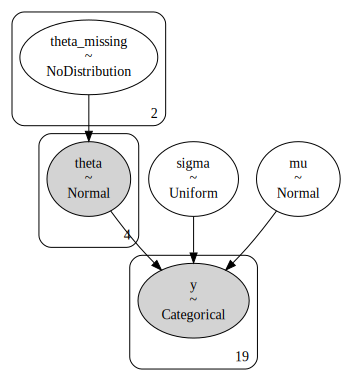

In [9]:
# Using the Theano @as_op decorator with a custom function to calculate the threshold probabilities.
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
# http://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Arbitrary-deterministics
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar], otypes=[tt.fvector])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty(nYlevels, dtype=np.float32)
    n = norm(loc=mu, scale=sigma)       
    out[0] = n.cdf(theta[0])        
    out[1] = np.max([0, n.cdf(theta[1]) - n.cdf(theta[0])])
    out[2] = np.max([0, n.cdf(theta[2]) - n.cdf(theta[1])])
    out[3] = np.max([0, n.cdf(theta[3]) - n.cdf(theta[2])])
    out[4] = 1 - n.cdf(theta[3])
    return out

with pm.Model() as ordinal_model_single:    
    
    theta = pm.Normal('theta',mu=thresh,tau=np.repeat(.5**2, len(thresh)),shape=len(thresh),observed=thresh_obs)
    
    mu = pm.Normal('mu', mu=nYlevels/2.0, tau=1.0/(nYlevels**2))
    sigma = pm.Uniform('sigma', nYlevels/1000.0, nYlevels*10.0)
          
    pr = outcome_probabilities(theta, mu, sigma)
        
    y = pm.Categorical('y', pr, observed=lk_27-1)
    
pm.model_to_graphviz(ordinal_model_single)

In [10]:
with ordinal_model_single:
    trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 305 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'theta_missing'}>,
        <AxesSubplot:title={'center':'theta_missing'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

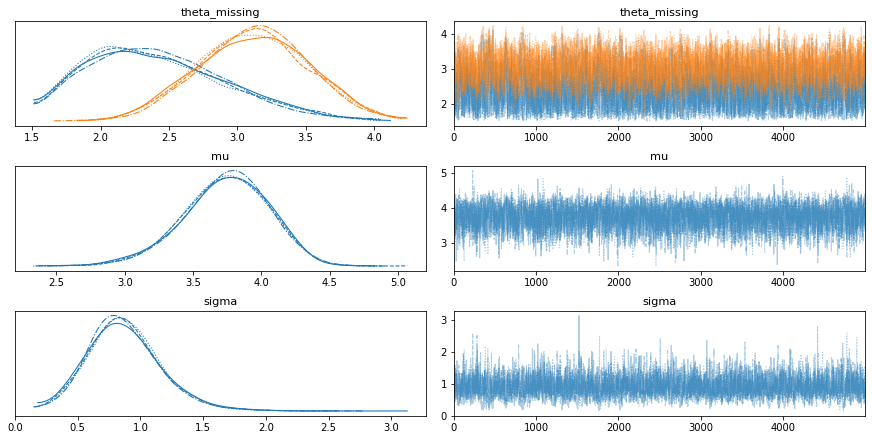

In [11]:
pm.traceplot(trace)

In [12]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta_missing[0],2.421,0.496,1.581,3.322,0.012,0.009,1676.0,1519.0,1880.0,1823.0,1.0
theta_missing[1],3.119,0.398,2.383,3.868,0.009,0.007,1810.0,1687.0,1785.0,1874.0,1.0
mu,3.742,0.306,3.170,4.300,0.005,0.004,3315.0,3225.0,3183.0,5118.0,1.0
sigma,0.875,0.285,0.360,1.416,0.006,0.004,2505.0,2505.0,2143.0,2040.0,1.0


In [36]:
def count_per_data_value(d,c,q):
    return np.array([ len(d[(d[q] == x) & (df.Community==c)][q]) for x in [1,2,3,4,5]])
count_per_data_value(df,'Comm.Linux_Kernel','V27')

array([ 0,  1,  3, 12,  3])

In [47]:
pd.Series(count_per_data_value(df,'Comm.Linux_Kernel','V33'))

0    1
1    5
2    7
3    5
4    0
dtype: int64

/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


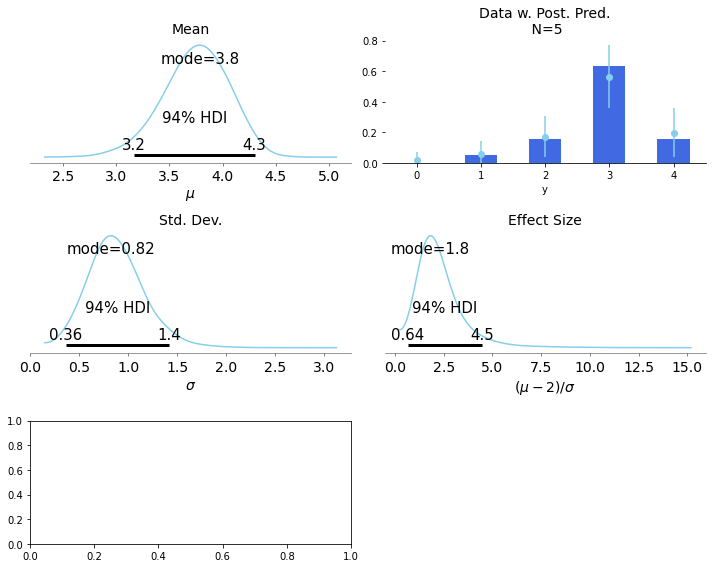

In [52]:
from matplotlib import gridspec
import seaborn as sns
color = '#87ceeb'
f_dict = {'size':14}
mu = trace['mu']
sigma = trace['sigma']

# Concatenate the fixed thresholds into the estimated thresholds
n = trace['theta_missing'].shape[0]
thresholds = np.c_[np.tile([1.5], (n,1)),
                   trace['theta_missing'],
                   np.tile([4.5], (n,1))]

# Define gridspec
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2,0])

# Mu
pm.plot_posterior(mu, point_estimate='mode', color=color, ax=ax1)
ax1.set_title('Mean', fontdict=f_dict)
ax1.set_xlabel('$\mu$', fontdict=f_dict)

# Posterior predictive probabilities of the outcomes
threshCumProb = np.empty(thresholds.shape)

for i in np.arange(threshCumProb.shape[0]):
    threshCumProb[i] = norm().cdf((thresholds[i] - mu[i])/sigma[i])
    
outProb = (np.c_[threshCumProb, np.tile(1, (thresholds.shape[0],1))] - np.c_[np.tile(0, (thresholds.shape[0],1)), threshCumProb])
yerr = np.abs(np.subtract(pm.hpd(outProb), outProb.mean(axis=0).reshape(-1,1)))

# (lk_27-1).value_counts(sort=False)
pd.Series((count_per_data_value(df,'Comm.Linux_Kernel','V27')/count_per_data_value(df,'Comm.Linux_Kernel','V27').sum())).plot.bar(ax=ax2, rot=0, color='royalblue')
ax2.errorbar(x = np.arange(nYlevels), y=outProb.mean(axis=0), yerr=yerr.T, color=color, fmt='o')
ax2.set_xlabel('y')
sns.despine(ax=ax2, left=True)
# ax2.yaxis.set_visible(False)
ax2.set_title('Data w. Post. Pred.\n N={}'.format(nYlevels), fontdict=f_dict)

# Sigma
pm.plot_posterior(sigma, point_estimate='mode', color=color, ax=ax3)
ax3.set_title('Std. Dev.', fontdict=f_dict)
ax3.set_xlabel('$\sigma$', fontdict=f_dict)

# Effect size
pm.plot_posterior((mu-2)/sigma,point_estimate='mode',  color=color, ax=ax4)
ax4.set_title('Effect Size', fontdict=f_dict)
ax4.set_xlabel('$(\mu-2)/\sigma$', fontdict=f_dict)

# Posterior distribution on the thresholds
# ax5.scatter(thresholds, np.tile(thresholds.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
# ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
# ax5.set_xlabel('Threshold', fontdict=f_dict)
# ax5.vlines(x = thresholds.mean(axis=0),
#            ymin=thresholds.mean(axis=1).min(),
#            ymax=thresholds.mean(axis=1).max(), linestyles='dotted', colors=color)

fig.tight_layout()

In [ ]:
print(thresholds.shape)
print(thresholds)
print(outProb)
print(outProb.mean(axis=0))
# print(yerr)
print(threshCumProb)
np.array([0,0.2, 0.6, 2.4, 0.6])/sum([0,0.2, 0.6, 2.4, 0.6])

In [ ]:
# yerr=np.array([[0.0171023,  0.05190606],
#                [0.05688711, 0.08563712],
#                [0.12881857, 0.14287911],
#                [0.20265695, 0.20335417],
#                [0.14917756, 0.16691846]])
x = [1,2,3,4,5]
y = outProb.mean(axis=0) #[0.0171023,  0.05695131, 0.16608955, 0.56333736, 0.19651949]
yData = np.array([0,0.2, 0.6, 2.4, 0.6])/sum([0,0.2, 0.6, 2.4, 0.6])#np.array([0.,0.05263158,0.15789474,0.63157895,0.15789474])
fig, ax = plt.subplots()
ax.bar(x,yData)
ax.errorbar(x=x, y=outProb.mean(axis=0), yerr=yerr.T, color='red',fmt='o', uplims=True, lolims=True,)
plt.show()
yerr.T